# Clustering ISGs  for HBECs

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
%matplotlib inline
import itertools

import statsmodels.formula.api as smf
import statsmodels.api as sm
pd.set_option('display.max_rows', 600)

In [2]:
import functools

In [3]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.7-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq')
import encode
import memento

In [4]:
data_path = '/data_volume/memento/hbec/'
# fig_path = '/data/home/Github/scrna-parameter-estimation/figures/fig6/'

In [5]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [6]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'large',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)

### Get data

In [7]:
adata = sc.read(data_path + 'HBEC_type_I_filtered_counts_deep.h5ad')

In [8]:
# adata = adata[:, ~adata.var.index.str.startswith('MT-')].copy()
# adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'basal/club' else 'bc')
# adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'ionocyte/tuft' else 'ion-tuft')

In [9]:
adata.shape

(69958, 36601)

In [10]:
converter = {'basal/club':'BC', 'basal':'B', 'ciliated':'C', 'goblet':'G', 'ionocyte/tuft':'IT', 'neuroendo':'N'}

In [11]:
adata.obs['ct'] = adata.obs['cell_type'].apply(lambda x: converter[x])
# adata_processed.obs['ct'] = adata_processed.obs['cell_type'].apply(lambda x: converter[x])

### Setup memento

In [12]:
def assign_q(batch):
    
    if batch == 0:
        return 0.387*0.25
    elif batch == 1:
        return 0.392*0.25
    elif batch == 2:
        return 0.436*0.25
    else:
        return 0.417*0.25

In [13]:
adata.obs['q'] = adata.obs['batch'].apply(assign_q)

In [14]:
memento.setup_memento(adata, q_column='q', trim_percent=0.1)

### Read 1D HT results

In [15]:
cts = ['C', 'B', 'BC', 'all_ct']
tps = [ '3', '6', '9', '24', '48']
stims = ['alpha', 'beta', 'gamma', 'lambda']

In [16]:
def read_result():
    
    ht_dict = {}
    moments_dict = {}
    
    for stim in stims:
        adata_subset = sc.read(data_path + '/binary_test_latest/C_{}_6.h5ad'.format(stim))
        ht_dict[stim] = memento.get_1d_ht_result(adata_subset)
        ht_dict[stim]['de_fdr'] = memento.util._fdrcorrect(ht_dict[stim]['de_pval'])
        ht_dict[stim]['dv_fdr'] = memento.util._fdrcorrect(ht_dict[stim]['dv_pval'])
        moments_dict[stim] = memento.get_1d_moments(adata_subset, groupby='time_step')
    return ht_dict,moments_dict

In [17]:
ht, moments = read_result()

In [18]:
t1_de_genes = ht['beta'].query('de_coef > 0.5 & de_fdr < 0.05')
t2_de_genes = ht['gamma'].query('de_coef > 0.5 & de_fdr < 0.05')

### Coexpression

In [19]:
def get_gxg_matrix(adata, genes):

    memento.compute_2d_moments(adata, list(itertools.combinations(genes, 2)))
    
    moments = memento.get_2d_moments(adata, groupby='group')
    
    gxg_matrix = pd.DataFrame(index=genes, columns=genes)
    for idx, row in moments.iterrows():
        gxg_matrix.loc[row['gene_1'], row['gene_2']] = row['group_1']
        gxg_matrix.loc[row['gene_2'], row['gene_1']] = row['group_1']
    gxg_matrix = gxg_matrix.fillna(0.0)
#     gxg_matrix = moments.pivot('gene_1', 'gene_2', 'group_1').fillna(0.0)
#     gxg_matrix[gxg_matrix.columns] = gxg_matrix.values + gxg_matrix.values.T
    gxg_matrix = gxg_matrix.loc[list(set(gxg_matrix.columns) & set(gxg_matrix.index)), list(set(gxg_matrix.columns) & set(gxg_matrix.index))]
    
    return gxg_matrix

In [67]:
ct = ['C']
adata_ctrl = adata.copy()[
    adata.obs.ct.isin(ct) & \
    adata.obs.stim.isin(['control'])].copy()
adata_stim = adata.copy()[
    adata.obs.time.isin(['6']) & \
    adata.obs.ct.isin(ct) & \
    adata.obs.stim.isin(['beta'])].copy()
adata_gamma = adata.copy()[
    adata.obs.time.isin(['6']) & \
    adata.obs.ct.isin(ct) & \
    adata.obs.stim.isin(['gamma'])].copy()
adata_ctrl.obs['group'] = 1
adata_stim.obs['group'] = 1
adata_gamma.obs['group'] = 1

memento.create_groups(adata_ctrl, label_columns=['donor', 'group'])
memento.compute_1d_moments(adata_ctrl, min_perc_group=.9)
memento.create_groups(adata_stim, label_columns=['donor', 'group'])
memento.compute_1d_moments(adata_stim, min_perc_group=.9)
memento.create_groups(adata_gamma, label_columns=['donor', 'group'])
memento.compute_1d_moments(adata_gamma, min_perc_group=.9)


gene_list = list( set(adata_ctrl.var.index) & set(adata_stim.var.index) & set(t1_de_genes.gene.tolist() ))

ctrl_gxg = get_gxg_matrix(adata_ctrl, gene_list)
stim_gxg = get_gxg_matrix(adata_stim, gene_list)
# gamma_gxg = get_gxg_matrix(adata_gamma, gene_list)

KeyboardInterrupt: 

### Cluster the stim data, see the control-stim matched correlations

In [23]:
from sklearn.cluster import AgglomerativeClustering

In [24]:
# num_cluster = 4

In [25]:
# working params: distance_threshold=15
clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=15).fit(ctrl_gxg.clip(upper=1, lower=-1))
# keep cluster 3
for cluster in range(clustering.labels_.max()+1):
    selector = np.where(clustering.labels_==cluster)[0]
    selected_stim_gxg = stim_gxg.iloc[selector, selector]
    selected_ctrl_gxg = ctrl_gxg.iloc[selector, selector]

    print(cluster, selector.shape[0], selected_stim_gxg.mean().mean(), selected_ctrl_gxg.mean().mean())
with open('ctrl_clustering.pkl','wb') as f:
    pkl.dump(clustering, f)

0 66 0.2693050983091503 0.11935129156523391
1 66 0.2115834655987534 0.1515613131370312
2 73 0.31221180746147553 0.2701744672586198
3 36 0.42924365433883843 0.3079232965322827
4 28 0.40631415173406576 0.3745589686749486
5 40 0.24972196490147242 0.2140726234136862
6 103 0.14404064483793977 0.03988763683479729
7 72 0.5704343368481165 0.5361414948166874
8 32 0.179903446016573 0.12579022689404235
9 43 0.3458875650081232 0.2710136154219226
10 56 0.44754502902273124 0.43126786908154097
11 1 0.0 0.0
12 1 0.0 0.0


In [26]:
clustering.labels_[ctrl_gxg.index.tolist().index('STAT2')]

2

In [27]:
clustering.labels_[ctrl_gxg.index.tolist().index('MX1')]

7

In [28]:
canonical_genes = ctrl_gxg.index[clustering.labels_==7].tolist() #+ ctrl_gxg.index[clustering.labels_==10].tolist()

In [29]:
print(canonical_genes)

['PARP14', 'MX1', 'IFIT2', 'PLAAT2', 'OAS1', 'PSMB9', 'EIF2AK2', 'HELZ2', 'CMPK2', 'DDX58', 'IFI6', 'MX2', 'RTP4', 'NUB1', 'CD38', 'APOL6', 'HLA-E', 'RSAD2', 'IRF9', 'SAMD9', 'GBP1', 'BST2', 'IFIH1', 'LAP3', 'OPTN', 'UBE2L6', 'ISG20', 'GBP4', 'SPATS2L', 'APOL1', 'ADAR', 'U62317.4', 'IDO1', 'IFIT1', 'WARS', 'SP110', 'IFI35', 'NT5C3A', 'PSMB8', 'IFITM1', 'TAP1', 'OAS3', 'DDX60L', 'STAT1', 'APOBEC3G', 'MYD88', 'TRIM22', 'ETV7', 'IFI27', 'IFI16', 'SP100', 'ISG15', 'IRF7', 'OASL', 'IFI44L', 'RNF213', 'EPSTI1', 'USP18', 'PARP12', 'IFI44', 'IFIT3', 'XAF1', 'SHFL', 'SAMD9L', 'PARP9', 'DDX60', 'PLSCR1', 'HERC5', 'OAS2', 'HERC6', 'IFITM3', 'NUPR1']


In [30]:
'PARP6' in gene_list

False

In [31]:
subset_stim_gxg = stim_gxg.loc[list(set(stim_gxg.index)-set(canonical_genes)), : ].loc[: , list(set(stim_gxg.index)-set(canonical_genes))]
subset_ctrl_gxg = ctrl_gxg.loc[list(set(stim_gxg.index)-set(canonical_genes)), : ].loc[: , list(set(stim_gxg.index)-set(canonical_genes))]

In [32]:
clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=15).fit(subset_stim_gxg.clip(upper=1, lower=-1))

# keep cluster 3
for cluster in range(clustering.labels_.max()+1):
    selector = np.where(clustering.labels_==cluster)[0]
    selected_subset_stim_gxg = subset_stim_gxg.iloc[selector, selector]
    selected_subset_ctrl_gxg = subset_ctrl_gxg.iloc[selector, selector]

    print(cluster, selector.shape[0], selected_subset_stim_gxg.mean().mean(), selected_subset_ctrl_gxg.mean().mean())
with open('stim_clustering.pkl','wb') as f:
    pkl.dump(clustering, f)

0 60 0.5854549681731079 0.2979394534123458
1 72 0.5198784498481381 0.18167606578619272
2 61 0.42774740598957023 0.1657666558419036
3 80 0.25365029533779865 0.13394642691289757
4 28 0.09001529855008138 0.05655669000761619
5 77 0.29462408704269333 0.1859810320290983
6 40 0.17728060425808795 0.0880747522778007
7 46 0.2657231000746266 0.07287158191130719
8 46 0.398602467633561 0.16912324986371027
9 35 0.21539205358235197 0.05691184697208648


In [33]:
clustering.labels_[subset_stim_gxg.index.tolist().index('HLA-A')]

1

In [34]:
noncanonical_genes_1 = subset_stim_gxg.index[clustering.labels_==1].tolist()
noncanonical_genes_2 = subset_stim_gxg.index[clustering.labels_==2].tolist()

noncanonical_genes_3 = subset_stim_gxg.index[clustering.labels_==8].tolist()

# noncanonical_genes_2 = subset_stim_gxg.index[clustering.labels_==6].tolist()

In [169]:
all_selected_genes = canonical_genes + noncanonical_genes_1 + noncanonical_genes_3 + noncanonical_genes_2

In [192]:
print(noncanonical_genes_2)

['KPNB1', 'TMEM175', 'UNC93B1', 'FNDC3A', 'GNB4', 'PALM2-AKAP2', 'RABGAP1L', 'LINC01138', 'NADK', 'RBMS2', 'GSDMB', 'SLFN5', 'XRN1', 'SCIN', 'USP42', 'MTG1', 'TAPBP', 'TRIM21', 'PI4K2B', 'HCP5', 'TAP2', 'SCLT1', 'BTN3A1', 'HIST2H2BE', 'NFE2L3', 'CMTR1', 'PTK2B', 'ATP13A3', 'R3HCC1L', 'ZFYVE26', 'SCARB2', 'OSBPL5', 'AC009133.1', 'PNPT1', 'TBX1', 'TRIM26', 'TRAFD1', 'SLC25A28', 'STX4', 'XPNPEP1', 'PLEKHA7', 'GTPBP1', 'TBC1D1', 'C5orf56', 'ICK', 'LAMP3', 'CHROMR', 'HSH2D', 'BISPR', 'JAK2', 'DOP1A', 'PRKD2', 'ZNFX1', 'KARS', 'SLC6A6', 'PML', 'OGFR', 'PARP8', 'WDFY1', 'CFLAR', 'RIPK1']


In [170]:
np.fill_diagonal(ctrl_gxg.values, 1)
np.fill_diagonal(stim_gxg.values, 1)

([], [])

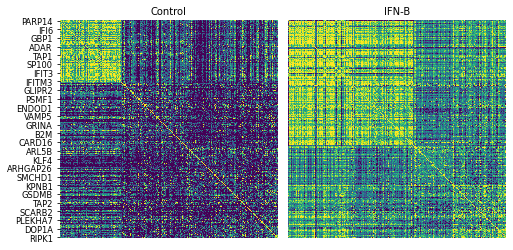

In [172]:
plt.figure(figsize=(8,4))
plt.subplots_adjust(wspace=0.05)

plt.subplot(1, 2, 1);
plt.title('Control')
sns.heatmap(ctrl_gxg.loc[all_selected_genes, all_selected_genes], vmin=0.1, vmax=0.7, cmap='viridis', cbar=None)
plt.axis('equal')
plt.xticks([])

plt.subplot(1, 2, 2);
plt.title('IFN-B')
sns.heatmap(stim_gxg.loc[all_selected_genes, all_selected_genes], vmin=0.1, vmax=0.7, cmap='viridis', cbar=None)
plt.axis('equal')
plt.xticks([])
plt.yticks([])

### Investigate other timepoints - coexpression

In [173]:
tps = ['3', '6', '9', '24', '48']

In [175]:
gxg_matrices = {}
for tp in tps:
    
    adata_tp = adata.copy()[
        adata.obs.time.isin([tp]) & \
        adata.obs.ct.isin(ct) & \
        adata.obs.stim.isin(['beta'])].copy()
    adata_tp.obs['group'] = 1

    memento.create_groups(adata_tp, label_columns=['donor', 'group'])
    memento.compute_1d_moments(adata_tp, min_perc_group=.9)
    
    tp_gene_list = [g for g in all_selected_genes if g in adata_tp.var.index]

    gxg_matrices[tp] = get_gxg_matrix(adata_tp, tp_gene_list).loc[tp_gene_list, tp_gene_list]
    np.fill_diagonal(gxg_matrices[tp].values, 1)


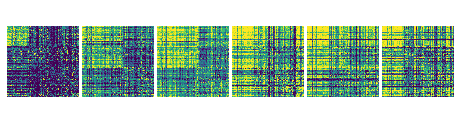

In [180]:
plt.figure(figsize=(8,2))
plt.subplots_adjust(wspace=0.05)

plt.subplot(1, 6, 1);
# plt.title('Control')
sns.heatmap(ctrl_gxg.loc[all_selected_genes, all_selected_genes], vmin=0.1, vmax=0.7, cmap='viridis', cbar=None)
plt.axis('equal')
plt.xticks([])
plt.yticks([])

for i, tp in enumerate(tps):

    plt.subplot(1, 6, i+2);
#     plt.title('IFN-B ' + tps[i] + 'hr')
    sns.heatmap(gxg_matrices[tp], vmin=0.1, vmax=0.7, cmap='viridis', cbar=None)
    plt.axis('equal')
    plt.xticks([]);
    plt.yticks([])
plt.savefig('ifnb_coex_tps.png', bbox_inches='tight', dpi=500)

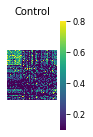

In [191]:
plt.figure(figsize=(7,2))
plt.subplots_adjust(wspace=0.05)

plt.subplot(1, 6, 1);
plt.title('Control')
sns.heatmap(ctrl_gxg.loc[all_selected_genes, all_selected_genes], vmin=0.1, vmax=0.8, cmap='viridis')
plt.axis('equal')
plt.xticks([])
plt.yticks([])
plt.savefig('ifnb_coex_tps_cbar.png', bbox_inches='tight', dpi=500)

### Mean single cell heatmaps

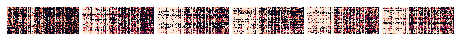

In [189]:
plt.figure(figsize=(8,0.5))
plt.subplots_adjust(wspace=0.05)
vmax=1
plt.subplot(1, 6, 1);
sns.heatmap(np.log(adata_ctrl[:, all_selected_genes].X.todense()+1), cbar=None, vmax=vmax)
plt.xticks([])
plt.yticks([])


for i, tp in enumerate(tps):
    
    plt.subplot(1, 6, i+2);
    adata_tp = adata.copy()[
        adata.obs.time.isin([tp]) & \
        adata.obs.ct.isin(ct) & \
        adata.obs.stim.isin(['beta'])].copy()
    sc.pp.normalize_total(adata_tp)
    sc.pp.log1p(adata_tp)
    tp_gene_list = [g for g in all_selected_genes if g in adata_tp.var.index]
    sns.heatmap(adata_tp[:, tp_gene_list].X.todense(), cbar=None, vmax=vmax)
    plt.xticks([]);
    plt.yticks([])
plt.savefig('ifnb_expr_tps.png', bbox_inches='tight', dpi=300)

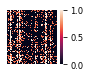

In [190]:
plt.figure(figsize=(7,1))
plt.subplots_adjust(wspace=0.05)
vmax=1
plt.subplot(1, 6, 1);
sns.heatmap(np.log(adata_ctrl[:, gene_list].X.todense()+1), vmax=vmax)
plt.xticks([])
plt.yticks([])
plt.savefig('ifnb_expr_tps_cbar.png', bbox_inches='tight', dpi=300)

### Tonic sensitivity

In [130]:
tonic_sensitivity_df = pd.read_csv('tonic_isg.txt', sep='\t')
tonic_sensitivity_df['gene'] = tonic_sensitivity_df['GeneSymbol'].str.upper()

In [131]:
tonic_sensitivity_df = pd.read_csv('tonic_isg.txt', sep='\t')
tonic_sensitivity_df['gene'] = tonic_sensitivity_df['GeneSymbol'].str.upper()
tonic_sensitivity_df = tonic_sensitivity_df[['gene', 'TonicIndex']].rename(columns={'TonicIndex':'Tonic Sensitivity'})

In [132]:
tonic_sensitivity_df['Tonic Sensitivity'] = np.log(tonic_sensitivity_df['Tonic Sensitivity'])

In [133]:
# tonic_sensitivity_df = moments['beta'][1].rename(columns={'time_step_0':'Baseline variability'}).merge(tonic_sensitivity_df, on='gene').query('gene in @t1_de_genes.gene.tolist()')

In [134]:
all_genes = moments['beta'][1].gene.tolist()

In [135]:
tonic_sensitivity_df = tonic_sensitivity_df#.query('gene in @all_genes').copy()

In [136]:
tonic_sensitivity_df.shape

(218, 2)

In [141]:
tonic_sensitivity_df['group'] = tonic_sensitivity_df['gene'].apply(lambda x: 'canon' if x in canonical_genes else 'non\ncanon')

In [142]:
tonic_sensitivity_df.group.value_counts()

non\ncanon    168
canon          50
Name: group, dtype: int64

<AxesSubplot:xlabel='group', ylabel='Tonic Sensitivity'>

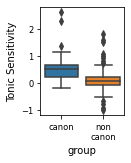

In [143]:
plt.figure(figsize=(1.5,2))
sns.boxplot(x='group', y='Tonic Sensitivity', data=tonic_sensitivity_df)

In [148]:
stats.mannwhitneyu(tonic_sensitivity_df.query('group == "canon"')['Tonic Sensitivity'], tonic_sensitivity_df.query('group == "non\\ncanon"')['Tonic Sensitivity'])

MannwhitneyuResult(statistic=1728.0, pvalue=1.3671383638522417e-10)

### Baseline variability

In [149]:
baseline = moments['beta'][1].query('gene in @all_selected_genes').copy()

In [152]:
baseline['group'] = baseline['gene'].apply(lambda x: 'canon' if x in canonical_genes else 'non\ncanon')

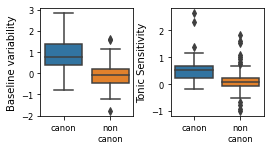

In [168]:
plt.figure(figsize=(4,2))
plt.subplots_adjust(wspace=0.4)

plt.subplot(1, 2, 1)
sns.boxplot(x='group', y='time_step_0', data=baseline);
plt.xlabel(None);
plt.ylabel('Baseline variability')
plt.subplot(1, 2, 2)

sns.boxplot(x='group', y='Tonic Sensitivity', data=tonic_sensitivity_df)
plt.xlabel(None);
plt.savefig('baseline_and_tonic.pdf', bbox_inches='tight')